26-1 들어가며 <br>
26-2 Base model and Dataset for RLHF <br>
26-3 Supervised Fine-Tuning <br>
26-4 Reward Model <br>
26-5 Proximal Policy Optimization <br>
26-6 마무리하며 <br>

In [ ]:
import torch

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
!pip list | grep transformers # transformers 4.28.0

### 26 - 2 Base model and Dataset for RLHF

LLM Trend Note1 노드에서 봤던 FLAN의 Instruction Tuning이나 PaLM의 Prompt Engineering 이 효과를 보기 위해선 언어모델의 입력을 단순한 query 형태로 주기보단 정교한 입력 시퀀스를 설계해야 한다고 배웠다. <br>
예컨대, 작업의 지시사항이 담긴 instruction과 실제 모델이 작업 내용이 담긴 input, 그리고 CoT(Chain of thought) 형태의 예시답안 등을 prompt로 주는 식으로 말이다. <br>
그런데 이렇게 긴 prompt를 입력할 수 있으려면 그만한 모델 capacity가 뒷받침 되어야 한다. 일단 수백에서 수천개의 token을 입력 벡터로 받아낼 수 있어야 하고, 각 토큰에 대한 충분한 셀프어텐션 연산이 가능한 트랜스포머 모듈이 쌓여야 한다. 우리가 backbone 모델로 사용할 KoGPT-2의 성능을 잠시 확인해볼까? 허깅페이스의 transformers를 사용하면 토크나이저와 모델을 간단히 불러올 수 있다. <br>

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [ ]:
tokenizer.max_model_input_sizes

In [ ]:
input_txt = "바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."

In [ ]:
tokens = tokenizer(input_txt).tokens()
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].numpy()

In [ ]:
pd.options.display.max_columns = 40
pd.options.display.max_rows = 60
df = pd.DataFrame([tokens, input_ids[0]], index=["kogpt-2_tokens", "Input_IDs"])
df

In [ ]:
max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2,
                             do_sample=False)
print(tokenizer.decode(output_beam[0]))

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, temperature=2.0, top_k=50)
print(tokenizer.decode(output_beam[0]))

<b> Q3. generate함수의 인자로 사용한 temperature, top_k 값은 어떤 효과를 주는 옵션인가요? </b> <br>

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, top_p=0.90)
print(tokenizer.decode(output_beam[0]))

최선의 디코딩 방법을 찾기 위해선 빔사이즈와 n-gram 패널티, temperature와 샘플링 인자로 조합할 수 있는 최선의 값을 찾아보는 실험이 필요하다. 다양한 입력 시퀀스로 실험을 해보면 더 좋지 않을까? <br>
베이스라인 모델로 사용한 kogpt-2의 일반적인 성능을 확인해봤으니 구체적인 instruction과 prompting을 사용해 어떻게 디코딩을 해내는지도 확인해보자. RLHF를 적용하기 전의 실험값을 정리해보면 KoChatGPT의 성능 개선 여부를 확인하는데 도움이 될 것이다. <br>
우리가 사용하는 kogpt-2는 오리지널 GPT2의 가장 작은 버전이다. 하단의 이미지는 GPT2논문의 table-2이다. 
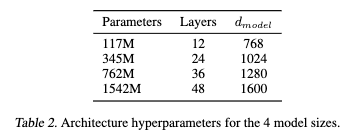 
[출처 : https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf]
emergent abilities를 기대할 수 있는 foundation model로는 많이 부족한 감이 있다. <br>

위에서 살펴본 것처럼 단순한 Causal LM에 불과한 kogpt-2는 생성해 낼 문장의 품질을 디코딩 단계에서 인위적으로 조절해주는 방법 밖에 쓸 수 없다. 하지만 RLHF를 kogpt-2에 적용한다면 더 좋은 문장을 생성해내는 방법을 모델이 스스로 학습해낼 수 있으리라 기대해 볼 수 있다. 고도의prompting은 어렵겠지만 현재 상태에서 특정 task에 fine-tuning했을 때보다는 성능이 한층 더 개선될 수 있지 않을까? <br>
kogpt-2에 RLHF를 적용하기기 위해선 새로운 데이터셋으로 일련의 재학습을 해줘야 한다. 그럼 각 단계별 모델 구현에 앞서 우리가 사용할 데이터셋을 확인해보도록 하겠다. 먼저 SFT를 시도할 initial 모델에 쓸 데이터셋을 살펴보자. <br>


### 데이터셋 확인
#### SFT

In [ ]:
import json 
data_path_1_SFT = 'aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

#### RM

In [ ]:
data_path_2_RM = 'aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

#### PPO

In [ ]:
data_path_3_PPO = 'aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

### 26-3 Supervised Fine-Tuning
#### SFT

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

In [ ]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

In [ ]:
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        data_path_1_SFT = 'aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl'
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [ ]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [ ]:
train_dataset = SFT_dataset(data_path_1_SFT='aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

In [ ]:
# 디코딩 함수를 작성해보세요.

In [ ]:
training_args = TrainingArguments(
    output_dir="aiffel/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [ ]:
trainer.train()
model.save_pretrained('aiffel/KoChatGPT/output_1_SFT')

In [ ]:
generator = pipeline('text-generation', model='aiffel/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

SFT 모델의 성능은 어떤가? SFT 단계를 최적화하기 위해선 무엇보다도 instruction dataset의 품질과 initial모델의 언어모델링 성능이 중요하다. GPT를 새로 pretrain 하여 언어모델 성능을 도약시키는 일은 우리의 학습목표를 넘어서는 일이니 우선은 데이터셋 전처리를 더 수행하고 최상의 디코딩 전략이 적용된 generator를 설계한다면 더 나은 성능을 기대해 볼 수 있을 것이다. 하지만 지금은 baseline을 빠르게 돌려보는 게 목적이다.
이제 다음 단계인 reward modeling으로 넘어가 보도록 하겠다. <br>

메모리 관리를 위해 캐시를 비우고 넘어가겠다. 

In [ ]:
torch.cuda.empty_cache()

### 26-4 Reward Model
#### RM

In [ ]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

Import된 라이브러리들을 보면 SFT단계에서 사용했던 것과는 다른 모듈들이 몇 개 눈에 띈다. 우선 chatgpt 폴더 안에 있는 RM 관련 모듈들이 눈에 띈다. NaiveStrategy라는 모듈도 있다. 원본 깃헙 레포짓에는 multi GPU를 사용해서도 KoChatGPT를 실습해볼 수 있도록 하고 있지만 우리는 single GPU를 사용해야 하는 환경이므로 학습전략을 고정시켜놓기 위해 해당 모듈을 따로 import했다. 마지막엔 허깅페이스의 transformers에서 gpt2 모델 관련 모듈들도 사용하고 있다.

In [ ]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

이제 SFT에서와 마찬가지로 사용할 모델과 토크나이저를 불러오겠음. with구문의 NaiveStrategy()는 chatgpt/trainer/strategies 폴더의 base 모듈에서 정의된 Strategy클래스를 상속한 NaiveStrategy클래스이다.

In [ ]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

In [ ]:
with open('aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

kochatgpt_2_RM.jsonl은 chatGPT, davinch, ada 세개 모델에 같은 prompt를 주고 얻은 세 답변을 순서대로 good, bad, worst로 간주해 순서를 뒤섞어 completion_0, completion_1, completion_2 세 키에 할당하여 만든 데이터셋이다. 위와 같이 코드를 짜게 되면 chosen과 resjected에 각각 completion_0, completion_1, completion_2 세개 답변이 가능한 모든 조합으로 들어가게 되어 chosen에 worst 답변이 들어가고 rejected에 good답변이 들어간 데이터도 만들어진다.

위와 같이 ranking dataset을 만들면 RM의 loss는 어떻게 계산이 되는 걸까? RM의 loss function은 pairwiseloss라는 이름으로 설계되어 있습니다.
아래 pairwiseloss 코드를 첨부했다. 원본 코드는 chatgpt/models 폴더의 loss.py 를 확인해보자.

In [ ]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

In [ ]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

In [ ]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

마지막으로 RM을 학습해보자. (SFT 훈련때와 마찬가지로 RM 훈련시 많은 자원이 소모된다. 모델 체크포인트를 활용할 수 있으니, 각각의 모델을 더 많은 데이터로 더 오래 훈련하고자 할 시, 커널을 초기화 한 후 재학습을 해보자. 지금은 빠르게 학습해보기 위해 1epoch만 돌려보도록 하겠다)

In [ ]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [ ]:
trainer.fit(use_lora=0)

model.save_pretrained('aiffel/KoChatGPT/output_2_RM')

In [ ]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

In [ ]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

In [ ]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."

output_reward = inference_RM(input_text=input_text)

In [ ]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

input text가 더 좋아질수록 reward score가 점진적으로 상승? 각 reward score 값이 적절한가? reward score가 음수가 된다는 건 어떤 의미일까? 그 전에 reward score가 음수도 될 수 있도록 하려면 어떻게 해야 할까?
RM의 출력인 reward score가 scalar가 되도록 하는 게 왜 중요할까? RLHF의 마지막 단계인 PPO 학습을 통해 살펴보도록 하겠다.
여기서도 메모리 관리를 위해 한 번더 캐시를 비우고 넘어가겠다.

In [ ]:
torch.cuda.empty_cache()

### 26-5 Proximal Policy Optimization
#### PPO

PPO에 사용할 actor모델은 1단계 SFT 모델을, critic모델은 2단계 RM 모델을 사용한다. 그리고 actor 모델이 critic 모델로부터 피드백을 받아 파라미터를 업데이트 할 때 적절한 페널티를 줄 수 있도록 하는 initial model은 SFT모델을 그대로 freezing 하여 사용한다. 토크나이저는 pretrain 모델인 kogpt-2의 토크나이저를 그대로 사용해야겠다.
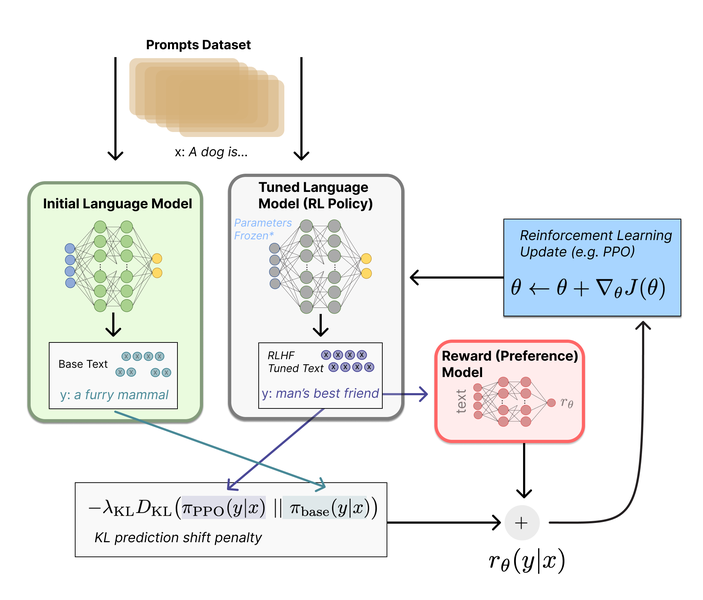

In [ ]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

노드에서 소개하는 KoChatGPT의 경우 PPO에 사용할 actor모델은 1단계 SFT 모델을, critic모델은 2단계 RM 모델을 사용한다.

그리고 actor 모델이 critic 모델로부터 피드백을 받아 파라미터를 업데이트 할 때 적절한 페널티를 줄 수 있도록 하는 initial model은 SFT모델을 그대로 freezing 하여 사용한다.

토크나이저는 pretrain 모델인 kogpt-2의 토크나이저를 그대로 사용해야함

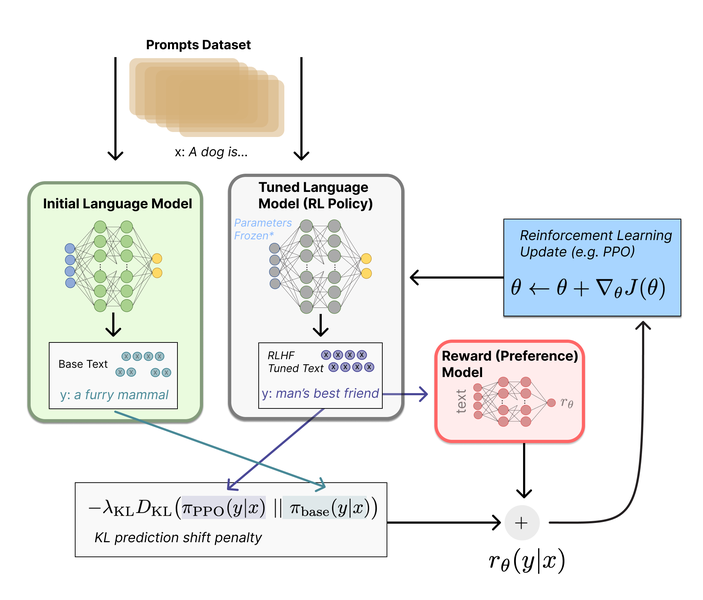 <br>

In [ ]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='aiffel/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [ ]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [ ]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [ ]:
with open('aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [ ]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

In [ ]:
len(list_prompt)

In [ ]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

위 코드 블럭의 원본 코드는 chatgpt/trainer 폴더 내의 ppo.py 모듈에서 확인할 수 있다. PPO는 SFT, RM 보다 훨씬 복잡한 단계로 설계되는 강화학습 알고리즘이다. PPO의 loss function은 chatgpt/models 폴더 내의 loss.py 모듈에서 PolicyLoss와 ValueLoss 클래스에 정의되어 있다.

In [ ]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('aiffel/KoChatGPT/output_3_PPO')

In [ ]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)

### 26-6 마무리하며 <br>

최종 모델 학습 결과는?

중복 토큰 생성 문제를 비롯해 맥락에서 벗어난 한문이나 영문이 출력되기도 한다. kogpt-2에 SFT만 적용했을 때와 비교해보면 큰 차이를 느끼지 못할 수도 있다. 각 단계에서 사용되는 데이터셋을 충분히 정제하고, 훈련 사이클을 늘려 정교하게 디코딩한다면 훨씬 나은 성능을 기대해볼 수 있다.

RLHF의 진가는 고도로 정제된 instruction dataset와 정교하게 설계된 보상체계로 학습되는 Reward model, 그리고 PPO 학습이 안정적으로 이뤄질 수 있도록 하는 충분한 크기의 foundation model이 뒷받침 되었을 때 발휘될 수 있다.

그러나 진짜 인간의 피드백이 반영된 데이터셋을 구축하기란 아주 어려운 일다. 첫 단계부터 큰 난관이라 할 수 있죠. 하지만 SFT만으로도 굉장히 훌륭한 언어모델을 만들 수 있다. 이준범님이 공개한koalpaca 모델이 대표적인 사례라 할 수 있다.


Q20. koalpaca는 foundation model로 어떤 모델들을 사용했나요? 
Q21. koalpaca의 레퍼런스 모델인 stanford alpaca가 사용한 모델과 데이터셋 그리고 학습방법은 무엇인가요?